# NLP Modeling

import neccessary libraries

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
# !pip install --upgrade scikit-learn

from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE, SMOTENC




In [143]:
#load cleaned dataset


In [144]:
df = pd.read_csv("./Data/Cleaned_tweet_dataset.csv")


# Binary Classification Simple Model

Start with a binary classification simple model only consider positive and negative sentiments for the target.

In [4]:
# Create a new dataframe for binary classification
df_binary = df [df['Emotion'] != 'Neutral']


In [5]:
df_binary.head()


,Unnamed: 0,Tweet,Brand/Product,Emotion,Brand
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple
4,4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google


In [6]:
#binarizing emotion column
emotion_dict = {'Negative': 0, 'Positive': 1}
df_binary['Emotion'] = df_binary['Emotion'].map(emotion_dict)


<ipython-input-6-c21124fb8c6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Emotion'] = df_binary['Emotion'].map(emotion_dict)


In [7]:
df_binary['Emotion'].value_counts(normalize= True)


1    0.839346
0    0.160654
Name: Emotion, dtype: float64

In [8]:
# we got class imbalance in our dataset so will use SMOTE to increase minority counts


In [9]:
# Define X, y
# Train-test-split
X = df_binary['Tweet'] # Tweet content is our feature
y = df_binary['Emotion'] #binary target for negative and positive emotions

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) # split data into training and testing


Dummy Classifier as a baseline to evaluate other model performances

In [10]:
tokenizer = TweetTokenizer()
# preserve_case = False, strip_handles = True

In [11]:
stop_lst = stopwords.words('english') + list(string.punctuation) + ['...','#sxsw', '’', '#sxswi', 'sxsw', "''", 'link','rt'] + ['ipad', 'apple', 'google', 'iphone', '#apple', 
                               '#google', '#ipad', '#iphone', 'android']

In [47]:
# Create a pipeline 
dummy_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('dumm', DummyClassifier(random_state=42))]) # first attempt: dummy classifier

dummy_pipe.fit(X_train, y_train)





/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('dumm', DummyClassifier(random_state=42))])

In [48]:
y_pred = dummy_pipe.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      1.00      0.27       137
           1       0.00      0.00      0.00       750

    accuracy                           0.15       887
   macro avg       0.08      0.50      0.13       887
weighted avg       0.02      0.15      0.04       887



/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [49]:
accuracy_score(y_test, y_pred)

0.1544532130777903

In [50]:
cm1 = confusion_matrix(y_test,y_pred)
cm1

array([[137,   0],
       [750,   0]])

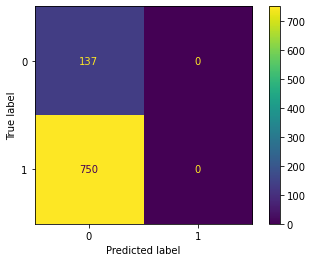

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

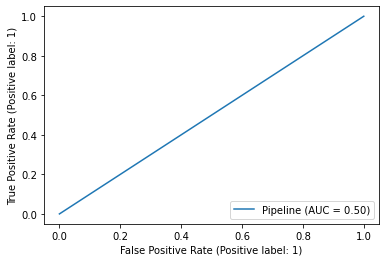

In [52]:
RocCurveDisplay.from_estimator( dummy_pipe, X_test, y_test )

In [53]:
# This dummy classifier model performs very bad with a 0.154 accuracy. AUC score of 0.5.
# Will see how Random forest perform with similar pipeline steps!

# Random Forest Baseline Model

In [54]:
# Create a pipeline for random forest.
rfc_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('rfc', RandomForestClassifier(random_state=42))]) # first attempt: Random forest classifier

rfc_pipe.fit(X_train, y_train) 

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [55]:
y_pred = rfc_pipe.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.28      0.41       137
           1       0.88      0.99      0.93       750

    accuracy                           0.88       887
   macro avg       0.83      0.63      0.67       887
weighted avg       0.87      0.88      0.85       887



In [56]:
accuracy_score(y_test, y_pred)

0.8759864712514093

In [57]:
recall_score(y_test, y_pred)

0.9853333333333333

In [58]:
cm2 = confusion_matrix(y_test,y_pred)
cm2

array([[ 38,  99],
       [ 11, 739]])

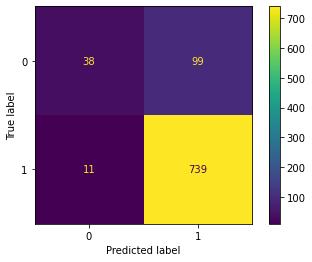

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

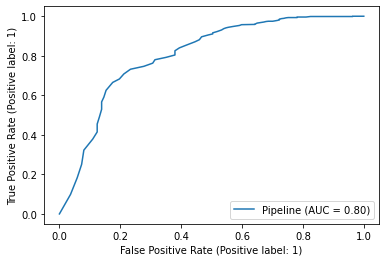

In [60]:
RocCurveDisplay.from_estimator( rfc_pipe, X_test, y_test )

Comparing this baseline random forest model with dummy model, this one performs much better with an accuracy of 0.875
and an AUC score of 0.80. However, the recall score indicates that it's only to predict negative tweets at 28% correctly. This model can predict the positive tweets at 99% correct. Will tune the model to see if we can improve these scores.

# Perform GridSearch on random forest

In [65]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__max_depth'] = [10, 20, None]
params['rfc__min_samples_leaf'] = [1,2,3]
params['vectorizer__norm']: ['l1','l2']


gs_rfc = GridSearchCV(estimator= rfc_pipe,
                 param_grid=params,
                 scoring='recall_macro',
                 n_jobs = 2,
                 verbose= 3)


In [66]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...],
                                                        tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [10, 20, None],
                         'rfc__min_samples_leaf': [1, 2, 3]},
             scoring='recall_macro', verbose=3)

In [67]:
gs_rfc.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__min_samples_leaf': 3}

Random Forest with best parameters:

In [72]:
rfc_best_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('rfc', RandomForestClassifier(criterion = 'gini',
                                                    max_depth = None,
                                                    min_samples_leaf = 3,
                                                    random_state = 42))]) # revised based on best_params

rfc_best_pipe.fit(X_train, y_train) 

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('rfc',
                 RandomForestClassifier(min_samples_leaf=3, random_state=42))])

In [73]:
y_pred = rfc_best_pipe.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.29      0.39       137
           1       0.88      0.96      0.92       750

    accuracy                           0.86       887
   macro avg       0.73      0.63      0.66       887
weighted avg       0.84      0.86      0.84       887



The recall for predicting positive and negative do not increase much with the gripsearch.

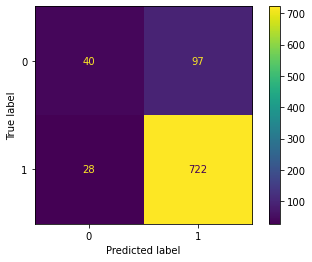

In [74]:
cm3 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot()
plt.show()


This model increase false negatives or it predicts more false negative reviews.

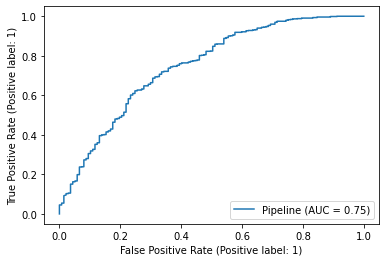

In [75]:
RocCurveDisplay.from_estimator( rfc_best_pipe, X_test, y_test )

AUC 0.75 is less than the baseline random forest model.

# 1st logistic regression model

In [96]:
# Create a pipeline for a baseline logistic regression model
logreg_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)), 
    ('smote', SMOTE(sampling_strategy = 1, random_state = 42)),
    ('lr', LogisticRegression(random_state=42))
])

logreg_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr', LogisticRegression(random_state=42))])

In [97]:
y_pred = logreg_pipe.predict(X_test)

In [98]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       137
           1       0.91      0.90      0.91       750

    accuracy                           0.84       887
   macro avg       0.70      0.70      0.70       887
weighted avg       0.84      0.84      0.84       887



In [99]:
accuracy_score(y_test, y_pred)

0.8421645997745209

In [100]:
recall_score(y_test, y_pred)

0.904

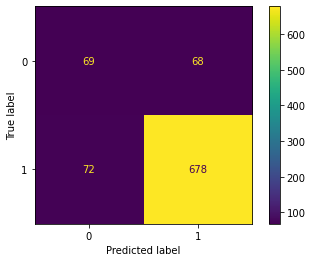

In [101]:
cm4 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4)
disp.plot()
plt.show()

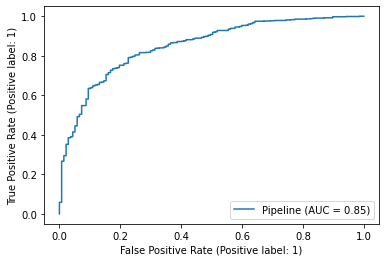

In [102]:
RocCurveDisplay.from_estimator(logreg_pipe , X_test, y_test )

Comparing this baseline logistic regression model with baseline random forest model, the random forest one still performs better
with higher scores.

# Perform GridSearch on Logistic Regression

In [105]:
params = {}
params['lr__class_weight'] = ['balanced']
params['lr__max_iter'] = [100, 200, 300, 500, 700,1000]
params['lr__C'] = [0.01, 0.1, 1]
params['lr__solver']: ['liblinear', 'lbfgs', 'sag','saga', 'newton-cholesky']



gs_logreg = GridSearchCV(estimator=logreg_pipe, 
                              param_grid = params, 
                              scoring='accuracy')


In [106]:
gs_logreg.fit(X_train,  y_train)
gs_logreg.best_params_

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarn

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarn

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarn

{'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 100}

# Tuned Logistic Regression Model with best parameters from gridSeach

In [109]:
# 'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 100
# Create a pipeline for a best tuned logistic regression model
logreg_best_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)), 
    ('smote', SMOTE(sampling_strategy = 1, random_state = 42)),
    ('lr', LogisticRegression(random_state=42,
                             C = 1,
                             class_weight = 'balanced',
                             max_iter = 100))
])

logreg_best_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=42))])

In [110]:
y_pred = logreg_best_pipe.predict(X_test)


In [112]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.49      0.50      0.50       137
           1       0.91      0.90      0.91       750

    accuracy                           0.84       887
   macro avg       0.70      0.70      0.70       887
weighted avg       0.84      0.84      0.84       887



In [113]:
accuracy_score(y_test, y_pred)


0.8421645997745209

In [114]:
recall_score(y_test, y_pred)


0.904

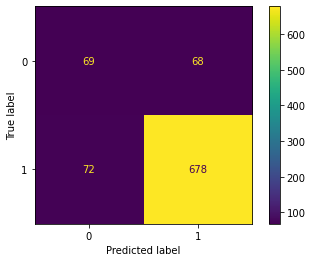

In [115]:
cm5 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5)
disp.plot()
plt.show()


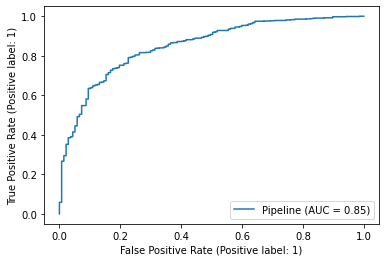

In [116]:
RocCurveDisplay.from_estimator(logreg_best_pipe , X_test, y_test )


This result this very similar to the baseline logistic regression.

both with accuracy of 0.84 and recall of 0.90.

First random forest model is still the best model. It has default parameters.

# Multiclass classification

In [145]:
# Use the whole dataset to analyze for all 3 emotions


In [146]:
# mapping emotion column to numerical values
emotion_dict = {'Negative': 0, 'Neutral':1, 'Positive': 2}
df['Emotion'] = df['Emotion'].map(emotion_dict)
df['Emotion'].value_counts()


1    5388
2    2978
0     570
Name: Emotion, dtype: int64

In [147]:
# Define X and y, train test split
y = df['Emotion']
X = df['Tweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [148]:
# check class imbalance
y_train.value_counts(normalize = True)


1    0.601611
2    0.337064
0    0.061325
Name: Emotion, dtype: float64

In [149]:
# Need to use smote to bring up the 0 and 2.


Dummy Classifier Model for multi-class


In [150]:
# Create a pipeline 
dummy_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 'auto', random_state = 42)), # use SMOTE to get the 2 minorities up
                     ('dumm', DummyClassifier(random_state=42))]) # first attempt: dummy classifier for multi-class

dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42)),
                ('dumm', DummyClassifier(random_state=42))])

In [151]:
y_pred = dummy_pipe.predict(X_test)


In [152]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.07      1.00      0.13       159
           1       0.00      0.00      0.00      1356
           2       0.00      0.00      0.00       719

    accuracy                           0.07      2234
   macro avg       0.02      0.33      0.04      2234
weighted avg       0.01      0.07      0.01      2234



/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [153]:
accuracy_score(y_test, y_pred)

0.0711727842435094

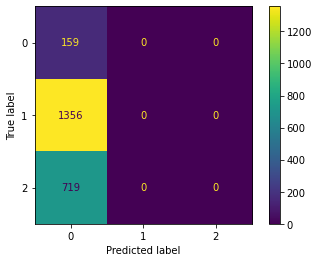

In [157]:
cm6 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm6)
disp.plot()
plt.show()

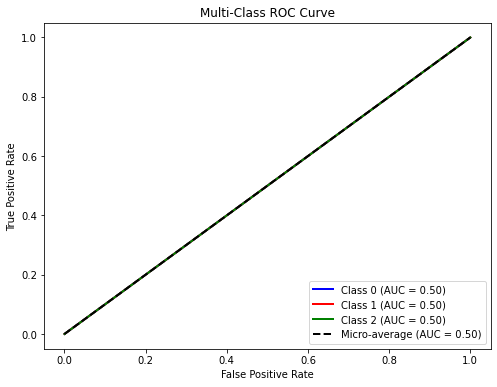

In [161]:
y_scores = dummy_pipe.predict_proba(X_test)

# Binarize the true labels for each class
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_index in range(len(np.unique(y))):
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], y_scores[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))

colors = ['blue', 'red', 'green', 'orange']
for class_index, color in zip(range(len(np.unique(y))), colors):
    plt.plot(fpr[class_index], tpr[class_index], color=color, lw=2,
             label='Class {} (AUC = {:.2f})'.format(class_index, roc_auc[class_index]))

# Plot the micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='black', linestyle='--', lw=2,
         label='Micro-average (AUC = {:.2f})'.format(roc_auc_micro))

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

This dummy model is so bad. no doubt. with AUC of 0.5, and accuracy of 0.07.

# Baseline Random Forest model for multi-class

In [164]:
# Create a pipeline 
rfc_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 'auto', random_state = 42)), # use SMOTE to get the 2 minorities up
                     ('rfc', RandomForestClassifier(random_state=42))]) # Random forest classifier

rfc_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [165]:
y_pred = rfc_pipe.predict(X_test)

In [167]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.21      0.32       159
           1       0.71      0.83      0.76      1356
           2       0.59      0.49      0.54       719

    accuracy                           0.68      2234
   macro avg       0.65      0.51      0.54      2234
weighted avg       0.67      0.68      0.66      2234



In [168]:
accuracy_score(y_test, y_pred)

0.6763652641002685

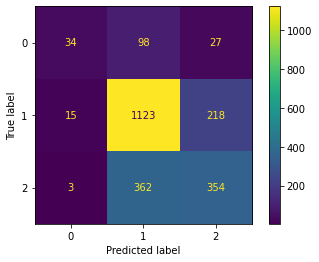

In [170]:
cm7 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm7)
disp.plot()
plt.show()

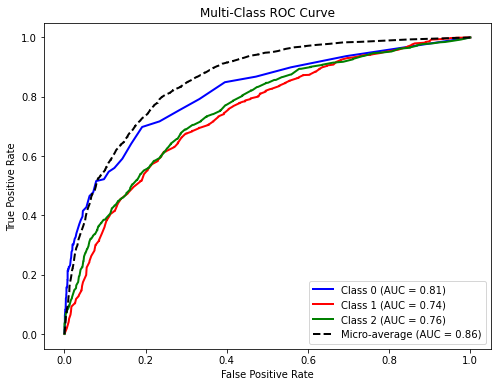

In [172]:
y_scores = rfc_pipe.predict_proba(X_test)

# Binarize the true labels for each class
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_index in range(len(np.unique(y))):
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], y_scores[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))

colors = ['blue', 'red', 'green', 'orange']
for class_index, color in zip(range(len(np.unique(y))), colors):
    plt.plot(fpr[class_index], tpr[class_index], color=color, lw=2,
             label='Class {} (AUC = {:.2f})'.format(class_index, roc_auc[class_index]))

# Plot the micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='black', linestyle='--', lw=2,
         label='Micro-average (AUC = {:.2f})'.format(roc_auc_micro))

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

Baseline random forest model for 3 class yields an accuracy of 67.6%, AUC score of 0.81 for class 0 (negative), 0.74
for class 1 (neutral), and 0.76 for class 2 (positive). Average of 0.86.

# GridSearch on random forest classfication:

In [173]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__max_depth'] = [10, 20, None]
params['rfc__min_samples_leaf'] = [1,2,3]
params['vectorizer__norm']: ['l1','l2']


gs_rfc = GridSearchCV(estimator= rfc_pipe,
                 param_grid=params,
                 scoring='accuracy',
                 n_jobs = 2,
                 verbose= 3)


In [174]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...],
                                                        tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [10, 20, None],
                         'rfc__min_samples_leaf': [1, 2, 3]},
             scoring='accuracy', verbose=3)

In [176]:
gs_rfc.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__min_samples_leaf': 1}

Try on a pipeline with Best parameters from gripSearch 

In [177]:
# Create a pipeline 
rfc_best_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 'auto', random_state = 42)), # use SMOTE to get the 2 minorities up
                     ('rfc', RandomForestClassifier(random_state=42,
                                                   criterion = 'gini',
                                                   max_depth = None,
                                                   min_samples_leaf = 1))]) # Random forest classifier

rfc_best_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7facefac7700>>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [178]:
y_pred = rfc_best_pipe.predict(X_test)

In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.21      0.32       159
           1       0.71      0.83      0.76      1356
           2       0.59      0.49      0.54       719

    accuracy                           0.68      2234
   macro avg       0.65      0.51      0.54      2234
weighted avg       0.67      0.68      0.66      2234



It doesn't seem like the model has imporved compared to the baseline.